<h1>Pneumonia detection using PyTorch and transfer learning:</h1>

In [ ]:
# ! nvidia-smi --query   # shows Google Colab's GPU type (NVIDIA Tesla T4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Connecting to Google Drive
import yaml
import h5py
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms, models
import torchvision.models as models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensor
# ToTensorV2 requires !pip install albumentations==0.4.6
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# loading .yml file with preset hyperparameters:
config = yaml.safe_load(open('/content/drive/My Drive/X-Ray-pneumonia-with-CV/model-parameters.yml', 'r'))
print('PyTorch version: ', torch.__version__)
print('Albumentations version: ', A.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(torch.backends.cudnn.enabled, torch.cuda.is_available())

<h2>The original images preprocessing and applying augmentations:</h2> 

In [ ]:
'''
Using Albumentations tools:

train_transforms = A.Compose([
                  A.Resize(width = config.get('img_size'), height = config.get('img_size')),
                  A.HorizontalFlip(p = 0.5),
                  A.RandomBrightnessContrast(p = 0.2),
                  A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                  ToTensorV2(),
])

val_transforms = A.Compose([
                  A.Resize(width = config.get('img_size'), height = config.get('img_size')),
                  A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                  ToTensorV2()
])

test_transforms = A.Compose([
                  A.Resize(width = config.get('img_size'), height = config.get('img_size')),
                  A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                  ToTensorV2()
])
'''
train_transforms = transforms.Compose([
                  transforms.Resize((config.get('img_size'), config.get('img_size'))),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
                  transforms.Resize((config.get('img_size'), config.get('img_size'))), 
                  transforms.ToTensor(),
                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
                  transforms.Resize((config.get('img_size'), config.get('img_size'))), 
                  transforms.ToTensor(),
                  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/X-Ray-pneumonia-with-CV/train', train_transforms)
val_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/X-Ray-pneumonia-with-CV/val', val_transforms)
test_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/X-Ray-pneumonia-with-CV/test', test_transforms)

# dataloaders for loading batches of instances:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = config.get('batch_size'),
                                               shuffle = True, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = config.get('batch_size'),
                                             shuffle = False, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = config.get('batch_size'),
                                              shuffle = False, num_workers = 2)
# len(dataloader) = amount of batches in 1 epoch

print('Train: {} images, validation: {} images, test: {} images.'.format(len(train_dataset), len(val_dataset), len(test_dataset)))
classes = train_dataset.classes # Returns list of classes' names: ['NORMAL', 'PNEUMONIA']

In [ ]:
print(train_dataset.class_to_idx) # {'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
images, labels = iter(train_dataloader).next()
print(images.shape) # Batch's size

torch.Size([32, 3, 224, 224])


<h2>Visualizations:</h2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


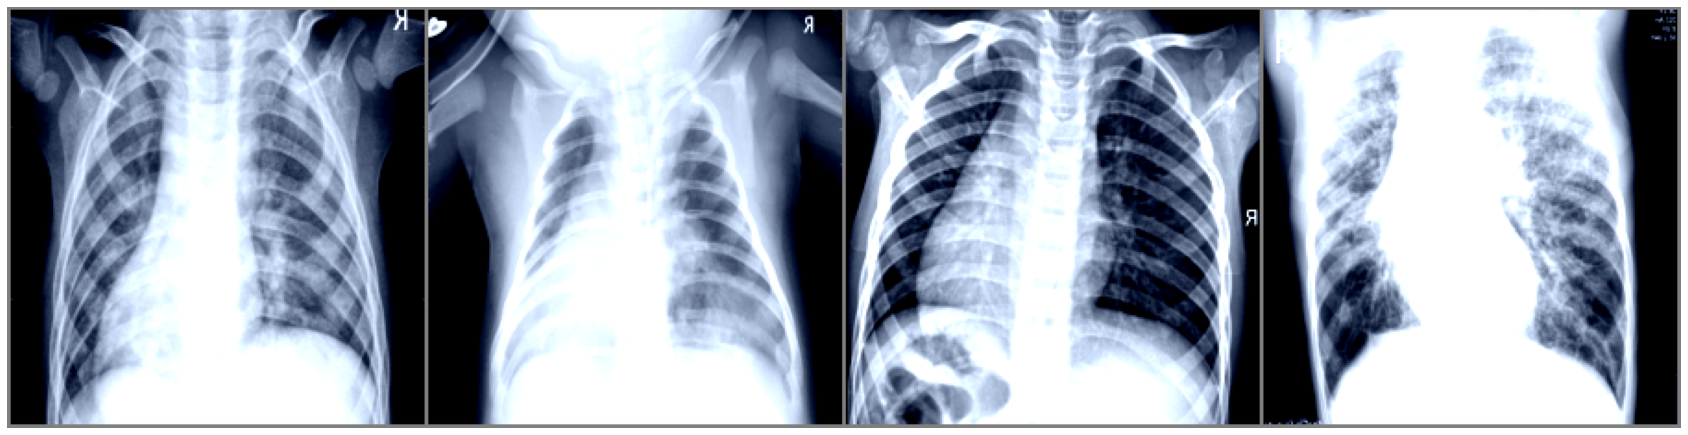

PNEUMONIA PNEUMONIA NORMAL PNEUMONIA


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.rcParams['figure.figsize'] = (30, 30)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images:
dataloader_for_showing = torch.utils.data.DataLoader(
                          train_dataset, batch_size = 4, shuffle = True)

dataiter = iter(dataloader_for_showing)
images, labels = dataiter.next()
# show images:
imshow(torchvision.utils.make_grid(images))
# print labels:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
counter = []
for i in train_dataset:
  if i[1] == 1:
    counter.append('PNEUMONIA')
  else:
    counter.append('NORMAL')

print('Train dataset:')
print('Normal:', counter.count('NORMAL'), '/ Pneumonia:', counter.count('PNEUMONIA'))
sns.set(rc = {'figure.figsize': (10, 10)})
sns.set(font_scale = 2, style = 'darkgrid')
sns.countplot(x = counter, linewidth = 1.5, edgecolor = sns.color_palette('dark', 1),
              palette = 'gnuplot2').set_title("Amounts of 'normal' and 'pneumonia' images \n in train dataset:")

plt.savefig('/content/drive/My Drive/X-Ray-pneumonia-with-CV/amounts_plot.png')

<h2>Building the model:</h2>

In [ ]:
# Saving losses and accuracies for further visualization:
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}

In [ ]:
model = models.resnet50(pretrained = True) # loading ResNet50 with weights
# I'm going to train the only last fully connected layer (linear classifier)

# Freeze all the parameters in the network
for param in model.parameters():
      param.requires_grad = False

# Adding fully connected layer, this is the only layer which is going to be learned in our neural net
model.fc = torch.nn.Linear(model.fc.in_features, len(classes)) # len(classes) = 2: 'normal' and 'pneumonia'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # Binary Cross Entropy between the target and the input probabilities
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = config.get('learning_rate'))

# Decay gradient descent step by a factor 0.1 every 7 epochs:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) # decay lr
num_epochs = config.get('epochs')

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs + 1):
        print('Epoch {}/{}:'.format(epoch, num_epochs), flush = True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0

            # Iterate over data:
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = criterion(preds, labels)
                    preds_class = preds.argmax(dim = 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush = True)

    return model

In [ ]:
# summary(model, input_size = (3, 224, 224))

***ResNet50*** has:

*   Total params: 23,512,130
*   Trainable params: 4,098
*   Non-trainable params: 23,508,032
*   Estimated Total Size: 376.82 MB


In [ ]:
%time
train_model(model, criterion, optimizer, scheduler, num_epochs)

Training the model took less than 25 minutes.

In [ ]:
# Saving the model with weights:
PATH = '/content/drive/My Drive/X-Ray-pneumonia-with-CV/X-ray-pytorch-model.pth'
torch.save(model.state_dict(), PATH)

<h2>Plotting accuracy and loss graphs</h2>

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (26, 8))
t = f.suptitle('Performance:', fontsize = 28)
f.subplots_adjust(top = 0.85, wspace = 0.3)

epoch_list = list(range(1, num_epochs + 2))
ax1.plot(epoch_list, accuracies['train'], label = 'Train Accuracy')
ax1.plot(epoch_list, accuracies['val'], label = 'Val Accuracy')
ax1.set_xticks(np.arange(0, num_epochs + 3, 3))
ax1.set_ylabel('Accuracy value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = 'best')

ax2.plot(epoch_list, losses['train'], label = 'Train Loss')
ax2.plot(epoch_list, losses['val'], label = 'Val Loss')
ax2.set_xticks(np.arange(0, num_epochs + 3, 3))
ax2.set_ylabel('Loss value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = 'best')

plt.savefig('/content/drive/My Drive/X-Ray-pneumonia-with-CV/acc_loss_graphs.png')

<h2>Loading the saved model:</h2>

In [ ]:
# Loading the trained model:

# Initializing the same class:
trained_model = models.resnet50(pretrained = False)
for param in trained_model.parameters():
      param.requires_grad = False
trained_model.fc = torch.nn.Linear(trained_model.fc.in_features, len(classes)) 

trained_model.load_state_dict(torch.load('/content/drive/My Drive/X-Ray-pneumonia-with-CV/X-ray-pytorch-model.pth'))
trained_model.eval(); # Sets the model to evaluation (inference) mode
# Switching the trained model to CUDA:
trained_model.to('cuda')
# Checking if trained_model is on CUDA:
print(next(trained_model.parameters()).is_cuda)

<h2>Predictions:</h2>

In [ ]:
# Predicting on the test dataset:

correct_count, all_count = 0, 0
for images, labels in test_dataloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, config.get('img_size'), config.get('img_size'))
    with torch.no_grad():
        logps = trained_model(img)

    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if (true_label == pred_label):
      correct_count += 1
    all_count += 1

print('Number of images tested: ', all_count)
print('Model accuracy: {:.3f}'.format(correct_count/all_count))

<h2>Confusion matrix:</h2>

Since we have to diagnose pneumonia, quite serious disease, we should to 
monitor FalseNegative metric and minimize it,
because diagnosing a sick person as a healthy is a huge mistake unlike diagnosing a healthy person as sick.
Therefore, Recall is our goal metric.

In [ ]:
y_true = []
y_pred = []
for images, labels in test_dataloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, config.get('img_size'), config.get('img_size'))
    with torch.no_grad():
        logps = trained_model(img)

    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    
    y_true.append(true_label)
    y_pred.append(pred_label)

# Plotting confusion matrix:
matplotlib.rcParams.update({'font.size': 30})

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print('Number of images tested: ', all_count)
print('Recall = {:.3f}'.format(tp / (tp + fn)))
print('Precision = {:.3f}'.format(tp / (tp + fp)))

cm = [[tn, fp],
      [fn, tp]]

df_cm = pd.DataFrame(cm, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12, 12))
sns.heatmap(df_cm, annot = True, cmap = 'Oranges',
            fmt = 'g', cbar = False,
            linewidths = 0.3, linecolor = 'black') # fmt changes scientific notation to integer format
plt.title('Confusion matrix:\n')
plt.xlabel('\nPredicted class:\n')
plt.ylabel('\nActual class:\n')
plt.savefig('/content/drive/My Drive/X-Ray-pneumonia-with-CV/confusion_matrix.png');

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

fpr, tpr, thresholds2 = roc_curve(y_true, y_pred)
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)

def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', linewidth = 4)
    plt.plot(thresholds, recalls[:-1], 'g-', linewidth = 4)
    plt.title('Precision vs. Recall Curve\n', fontdict = {'fontsize': 34})
    plt.xlabel('Thresholds')
    plt.ylabel('Precision/Recall values')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.grid(True, color = 'black')
    plt.show()

plt.figure(figsize = (12, 12))
plot_precision_recall(precisions, recalls, thresholds);
plt.savefig('/content/drive/My Drive/X-Ray-pneumonia-with-CV/precision-vs-recall-curve.png');

Precision and recall are at the optimum levels. It doesn't need reducing threshold, because I will obtain too small recall growth at the cost of strong decrease of precision. In this case FalsePositives will be incresed to a very large extent.

<h2>Making predictions with a few random images from test dataset:</h2>

In [ ]:
def show_image(image, title = None, get_denormalize = False):
    
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image*std + mean
    image = np.clip(image, 0, 1)
    
    if get_denormalize == False:
        plt.figure(figsize = [15, 15])
        plt.imshow(image)
        if title != None:
            plt.title(title)
    else : 
        return image

# Shows probabilities distribution:
def view_classify(img, ps, label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    
    ps = ps.cpu().data.numpy().squeeze()
    img = show_image(img, get_denormalize = True)

    fig, (ax1, ax2) = plt.subplots(figsize = (15, 15), ncols = 2)
    ax1.imshow(img)
    ax1.set_title('Actual label: {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted label:')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    return None

# Shows 3 random images from test dataset and probabilities distribution:
for i in np.random.randint(0, 1167, size = 3):
    image,label = test_dataset[i]
    plt.figure(figsize = (10, 10));
    ps = torch.exp(trained_model(image.to(device).unsqueeze(0)))
    view_classify(image,ps,label)